# Subset Gridded Static Inputs

>>> TODO: Info on Hydrodata static input gridded products here.
>>> subset_static by default gets 7 variables. Is that all there is in all datasets?

All products are gridded and you can see the projections and spatial resolution on the HydroData documentation page. 

Note that the subset tools and HydroData API tools do not provide any re-gridding options. Data will be returned at the spatial and temporal resolution of the initial dataset which is being subset.


#### Things to determine before you start
1. Before you start you should browse the [data catalog](https://maurice.princeton.edu/hydroframe/docs/gridded_data.html#dataset-type-parameters) and determine which static input dataset you would like to subset. 
2. Take note of the dataset name and the grid that is is available on as you will need this information for your subsetting. 
3. Also take note of the start and end dates of the dataset as well as the temporal resolution (e.g. hourly, daily), as these will set the limits of what you can subset.

### 1.  Setup 

In all examples you will need to import the following packages and register your pin in order to have access to the HydroData datasets

Refer to the [getting started](https://hydroframesubsettools.readthedocs.io/en/latest/getting_started.html) instructions for creating your pin if you have not done this already.

In [1]:
from subsettools.subsettools import huc_to_ij, latlon_to_ij, subset_static, subset_press_init
from hf_hydrodata import grid, gridded
from parflow.tools.io import read_pfb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

gridded.register_api_pin("your_email", "your_pin")

### 2. Define your area of interest

We use i,j indices in order to define the subset the national files that you would like to extract.  The [`latlon_to_ij`](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/subsettools/index.html#subsettools.subsettools.latlon_to_ij) function translates a bounding box in lat-lon  coordinates bounds to i,j indices in whatever grid system we select. It returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing our region (or point) of interest (Note: `(imin, jmin, imax, jmax)` are the west, south, east and north boundaries respectively).

Here we will show how to define a subset extent for (1) a single point of interest, (2) a user specified bounding box, and (3) a bounding box that surrounds a user specified HUC. 

**IMPORTANT NOTE**: *The i,j indices found in this step are based on whatever grid you select (e.g. `conus1` or `conus2`). Its very important that the grid you use in this step is the same as the grid that the static input files you are subsetting are in or you will end up subsetting a different location than you expect.  The grids are shown below and described in [Yang et al 2023](https://www.sciencedirect.com/science/article/pii/S0022169423012362)* 

![CONUS domains](CONUS1_2_domain.jpg)

#### 2.1 Defining bounds to extract data for a single point
To extract data for a single point we use the same bounding box function as we would to extract a larger domain but just repeat the point values as the upper and lower bounds.

In [3]:
lat = 39.8379
lon = -74.3791
# Since we want to subset only a single location, both lat-lon bounds are defined by this point:
latlon_bounds = ([lat, lon],[lat, lon])
ij_column_bounds = latlon_to_ij(latlon_bounds=latlon_bounds, grid="conus2")
print(f"bounding box: {ij_column_bounds}")

bounding box: (4057, 1915, 4057, 1915)


#### 2.2 Defining bounds for a box defined by lat-lon bounds
To extract a bounding box, provide the upper and lower latitude and longitude bounds respectively for the area of interest as well as the grid system that you would like to use. 

In [4]:
ij_box_bounds = latlon_to_ij(latlon_bounds=[[37.91, -91.43], [37.34, -90.63]], grid="conus1")
print(f"bounding box: {ij_box_bounds}")

bounding box: (2285, 436, 2358, 495)


#### 2.3 Defining bounds for a HUC watershed
The subsettools [`huc_to_ij`](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/subsettools/index.html#subsettools.subsettools.huc_to_ij) function returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing any HUC. You can provide 2, 4, 6, 8 or 10-digit HUCs.  For help finding your HUC you can refer to the [USGS HUC picker](https://water.usgs.gov/wsc/map_index.html).

In [5]:
ij_huc_bounds = huc_to_ij(huc_list=["14050002"], grid="conus2")
print(f"bounding box: {ij_huc_bounds}")

bounding box: (1225, 1738, 1347, 1811)


### 3.0 Subset the static input variables
There are two approaches to subsetting static data:
-  The [`subset_static`](https://hydroframesubsettools.readthedocs.io/en/api-fix/autoapi/subsettools/index.html#subsettools.subset_static) function will automatically get the forcing data for the 7 static input variables listed above and will write the data as pfb files into your output directory to be ready for a ParFlow run. You can modify this function to get a smaller list of variables if you would like.  
- The [`gridded.get_numpy`](https://maurice.princeton.edu/hydroframe/docs/hf_hydrodata.gridded.html#hf_hydrodata.gridded.get_numpy) function provides more direct access to the HydroData API and can return any subset variables of interest as a numpy array. 

#### 3.1 Subset static inputs with the `subset_static` function
This approach is recommended if you are planning on using the static inputs for a ParFlow run. By default, `subset_static` will get the data for all 7 static input variables (API reference [here](https://hydroframesubsettools.readthedocs.io/en/api-fix/autoapi/subsettools/index.html#subsettools.subset_static)) and write them out as PFBs (ParFlow Binary Files) for a ParFlow-CLM simulation. 

In addition to writing the files out the function returns a dictionary where the keys are static input variable names (e.g. 'slope_x', 'depth_to_bedrock', ...) and the values are the filepaths where the subset data for that variable were written. We will show how to use these paths to load the data into an array and plot them later in this tutorial.

**NOTE:** *Some datasets might not contain all 7 static input variables. In that case, the `subset_static` function is going to get and save the data for the variables supported by the dataset and print out a message for those that are not.*

**NOTE:** *As described above the grid that you use here must match the grid that was used to create the ij indices in step 2 and must also be consistent with the grid that the selected dataset is available on*


>>> TODO: conus2_domain does not support the depth_to_bedrock?

In [6]:
# Example grabbing all 7 static input variables
static_filepaths = subset_static(
    ij_huc_bounds,
    dataset="conus2_domain",
    write_dir="/home/ga6/subsettools_example",
)

Wrote slope_x.pfb in specified directory.
Wrote slope_y.pfb in specified directory.
Wrote pf_indicator.pfb in specified directory.
Wrote mannings.pfb in specified directory.
depth_to_bedrock not found in dataset conus2_domain
Wrote pme.pfb in specified directory.
Wrote ss_pressure_head.pfb in specified directory.


#### 3.2 Subset initial pressure data using the `subset_press_init` function
The [`subset_press_init`](https://hydroframesubsettools.readthedocs.io/en/api-fix/autoapi/subsettools/index.html#subsettools.subset_press_init) function will get and subset the initial pressure data at midnight on the date specified and write it out as a PFB (ParFlow Binary File). You can also specify a timezone argument, which defaults to UTC time. The returned data can then be used as initial conditions for a ParFlow simulation. The function returns a path to the file where the data is written.

>>> which dataset would I use for conus2? for conus1 it would be conus1_baseline_mod

In [ ]:
press_init_filepath = subset_press_init(
    ij_huc_bounds,
    dataset="some_dataset",
    date="2005-12-15",
    write_dir="/home/ga6/subsettools_example",
    time_zone="EST",
)

#### 3.3 Subset data using `gridded.get_numpy` function

>>> I haven't started on this part yet. Do we want to use `get_numpy` to get column data for static inputs, as we did for forcing? In that case, does it make sense to plot anything? (it's going to be a single point). Or I could use `get_numpy` to get the same data I got above, just in a different way.

The [`gridded.get_numpy`](https://maurice.princeton.edu/hydroframe/docs/hf_hydrodata.gridded.html#hf_hydrodata.gridded.get_numpy) function is a general function to extract any gridded data from HydroData. Here we illustrate how to use it grab out a set of static input variables. Here we show how to use this approach to grab out a single column of data but the function works the same if you provide it a bounding box. 

Note that this will just return the data as numpy array's and will not write them out for a ParFlow run so if you use this option and want to run ParFlow some additional steps will be required to write the data out. 

In [8]:
# list the variables that you would like to extract
forcing_vars = ('precipitation',
                'downward_shortwave',
                'downward_longwave',
                'specific_humidity',
                'air_temp',
                'atmospheric_pressure',
                'east_windspeed',
                'north_windspeed'
                )

forcing_data = {}
for var in forcing_vars:
    options = {"dataset": "CW3E",
               "grid": "conus2",
               "period": "hourly",
               "variable": var,
               "start_time": "2012-10-01",
               "end_time": "2013-10-01",
               "grid_bounds": ij_column_bounds
               }
    forcing_data[var] = gridded.get_numpy(options).squeeze()
    print(f"{var} loaded:", forcing_data[var].shape)

precipitation loaded: (8760,)
downward_shortwave loaded: (8760,)
downward_longwave loaded: (8760,)
specific_humidity loaded: (8760,)
air_temp loaded: (8760,)
atmospheric_pressure loaded: (8760,)
east_windspeed loaded: (8760,)
north_windspeed loaded: (8760,)


**Saving single column subset outputs** 
Here we illustrate how to combine the single column subset values into a single dataframe and save it out as a csv. Note that this CSV is formatted to be compatible as a single column forcing file input for ParFlow. Note that ParFlow expects a specific order and format, described more in the [manual here](https://parflow.readthedocs.io/en/latest/keys.html#clm-solver-parameters).

If you subset a bounding box of data with the functions above you could use the `write_pfb` function instead to write out files for the data. 

In [9]:
# Combine in a Pandas DataFrame in the order ParFlow expects
forcing_df = pd.DataFrame({"DSWR [W/m2]": forcing_data["downward_shortwave"],
                           "DLWR [W/m2]": forcing_data["downward_longwave"],
                           "APCP [mm/s]": forcing_data["precipitation"],
                           "Temp [K]": forcing_data["air_temp"],
                           "UGRD [m/s]": forcing_data["east_windspeed"],
                           "VGRD [m/s]": forcing_data["north_windspeed"],
                           "Press [pa]": forcing_data["atmospheric_pressure"],
                           "SPFH [kg/kg]": forcing_data["specific_humidity"]
                           })

# write to a ParFlow 1D forcing file
forcing_df.to_csv('forcing1D.txt', sep=' ',header=None, index=False, index_label=False)    

### 4.0 Visualize the data 
If you use the `subset_static` function, data will need to be read in first using the `read_pfb` function. If you use `get_numpy` the data are already available as a numpy array.

#### 4.1 loading and visualizing data that was written out using the `subset_static` function

>>> Should we plot the initial pressure data in addition to Mannings? It's just a matter of changing the filename below.

Here we use the `readpfb` function [from PFTools](https://parflow.readthedocs.io/en/latest/python/tutorials/pfb.html#loading-pfb-from-python)  to read the subset data in and plot it. We will plot Manning's constant over the whole bounding box. By replacing the filepath in the code below, we can plot any static input or the initial pressure data.

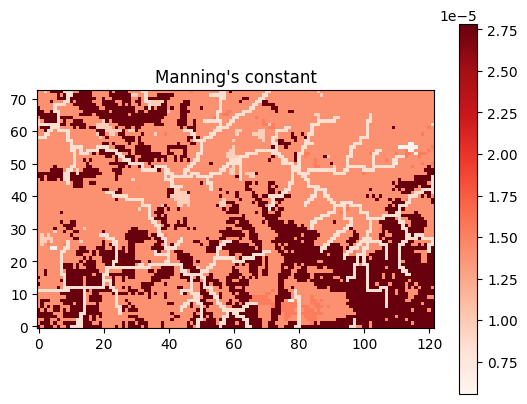

In [7]:
filename = static_filepaths["mannings"]
data = read_pfb(filename).squeeze()
plt.imshow(data, cmap="Reds", origin='lower')
plt.title("Manning's constant")
plt.colorbar()

#### 4.2 Visualize data that was subset using `gridded.get_numpy`

>>> I will edit this depending on the answer on the point above (about get_numpy).

Here we just visualize directly from the dataframe that was created in section 3.2. Note that you can also visualize your data from the numpy arrays directly and don't need to convert to a dataframe if you don't want to. 

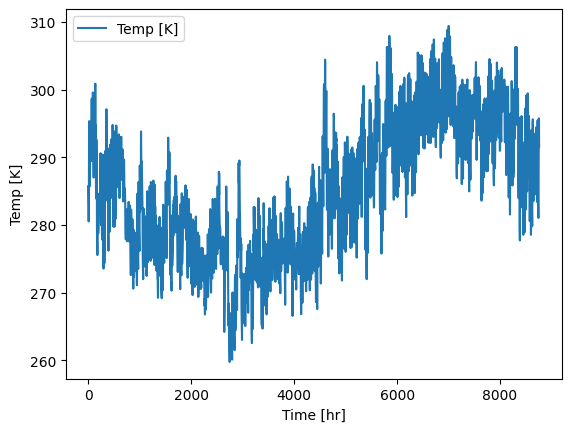

In [35]:
plt.plot(forcing_df['Temp [K]'], label='Temp [K]')
plt.xlabel('Time [hr]')  
plt.ylabel('Temp [K]')  
plt.legend()
plt.show()

### 5. Cite the data sources

Please make sure to cite all data sources that you use. The `get_catalog_entry` function (API reference [here](https://maurice.princeton.edu/hydroframe/docs/hf_hydrodata.gridded.html#hf_hydrodata.gridded.get_catalog_entry)) will return a dictionary of medatada based on our filters, from which we will select the `paper_dois` and `dataset_dois` keys. Note that since we requested static data, we need to specify a static period in our filters.

In [14]:
# metadata for static inputs from conus2_domain
metadata = gridded.get_catalog_entry(
    dataset="conus2_domain",
    grid="conus2",
    period="static",
    variable="slope_x",
)
print("Paper DOIs for static inputs:", metadata['paper_dois'])
print("Dataset DOI for static inputs:", metadata['dataset_dois'])

Paper DOIs for static inputs: 
Dataset DOI for static inputs: 


>>> TODO: citation for initial pressure data (need dataset for that)